In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np

In [88]:
phi2_df = pd.read_csv('phi2_preds_dataset_large.csv')
df = phi2_df.copy()
df['is_correct'] = df['is_correct'].astype(int)

In [89]:
from sklearn.model_selection import train_test_split

# Split with stratification to preserve class balance
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['is_correct']  # Critical for imbalanced data
)

In [4]:
# Initialize model (alternatives: 'multi-qa-mpnet-base-dot-v1' or 'all-mpnet-base-v2')
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
sent_train_embeddings = embedding_model.encode(
    train_df['question'].tolist(),
    show_progress_bar=True,
    convert_to_tensor=True  # Optimize for GPU if available
)
sent_train_embeddings = sent_train_embeddings.cpu().numpy()
sent_test_embeddings = embedding_model.encode(test_df['question'].tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [5]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_models(train_embeddings):
    # Logistic Regression (good baseline)
    lr_model = LogisticRegression(
        class_weight='balanced',  # Adjusts for class imbalance
        max_iter=1000,
        random_state=42
    )
    lr_model.fit(train_embeddings, train_df['is_correct'])

    # XGBoost (often better performance)
    xgb_model = XGBClassifier(
        scale_pos_weight=len(train_df[train_df['is_correct']==0])/len(train_df[train_df['is_correct']==1]),
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_model.fit(train_embeddings, train_df['is_correct'])

    return lr_model, xgb_model

def evaluate_model(model, embeddings, true_labels):
    preds = model.predict(embeddings)
    print(classification_report(true_labels, preds))

    # Confusion matrix visualization
    ConfusionMatrixDisplay.from_predictions(true_labels, preds)
    plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:31:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.67      0.55      0.60       122
           1       0.45      0.58      0.51        78

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.55       200
weighted avg       0.58      0.56      0.57       200



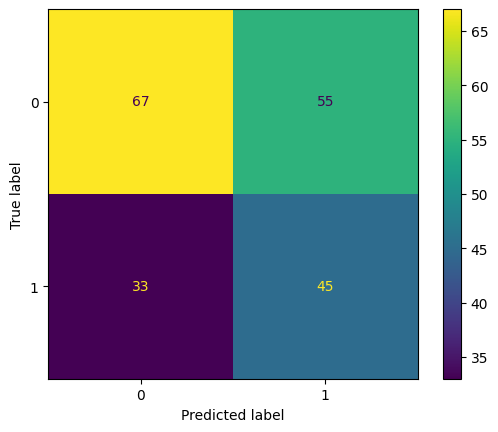


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       122
           1       0.44      0.29      0.35        78

    accuracy                           0.58       200
   macro avg       0.54      0.53      0.52       200
weighted avg       0.56      0.58      0.56       200



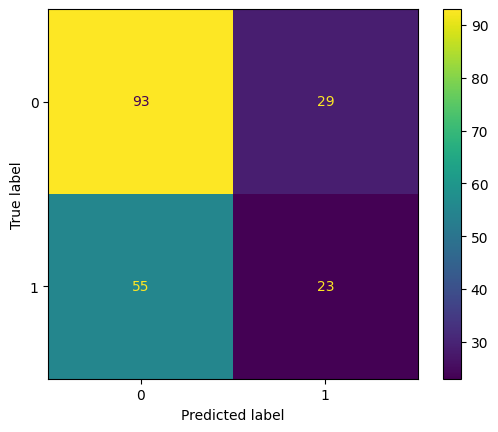

In [32]:
lr_model, xgb_model = get_models(sent_train_embeddings)

print("Logistic Regression Performance:")
evaluate_model(lr_model, sent_test_embeddings, test_df['is_correct'])

print("\nXGBoost Performance:")
evaluate_model(xgb_model, sent_test_embeddings, test_df['is_correct'])

In [6]:
from sklearn.metrics import f1_score

def get_stats(lr_model, xgb_model, test_embeddings):
    y_true = test_df['is_correct']
    y_pred = xgb_model.predict(test_embeddings)
    y_pred2 = lr_model.predict(test_embeddings)

    # For binary classification (focus on positive class)
    binary_f1 = f1_score(y_true, y_pred, average='binary')  # Default for binary
    binary_f12 = f1_score(y_true, y_pred2, average='binary')  # Default for binary

    # For class-balanced evaluation (equal weight to both classes)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    macro_f12 = f1_score(y_true, y_pred2, average='macro')

    # For imbalanced datasets (weighted by class support)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    weighted_f12 = f1_score(y_true, y_pred2, average='weighted')

    print(f"Binary F1 Score: {binary_f1:.2f}")
    print(f"Macro F1 Score: {macro_f1:.2f}")
    print(f"Weighted F1 Score: {weighted_f1:.2f}")

    print("\nLogistic regression:")
    print(f"Binary F1 Score: {binary_f12:.2f}")
    print(f"Macro F1 Score: {macro_f12:.2f}")
    print(f"Weighted F1 Score: {weighted_f12:.2f}")

In [34]:
get_stats(lr_model, xgb_model, sent_test_embeddings)

Binary F1 Score: 0.35
Macro F1 Score: 0.52
Weighted F1 Score: 0.56

Logistic regression:
Binary F1 Score: 0.51
Macro F1 Score: 0.55
Weighted F1 Score: 0.57


# Try 2

In [37]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

def generate_embeddings(texts, model, tokenizer):
    embeddings = []
    for text in texts:
        inputs = tokenizer(
            text,
            return_tensors="pt",
            max_length=512,
            truncation=True,
            padding="max_length"
        )
        with torch.no_grad():
            outputs = model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(emb)
    return np.array(embeddings)

# Usage for CodeBERT:
bert_train_embeddings = generate_embeddings(train_df['question'].tolist(), model, tokenizer)
bert_test_embeddings = generate_embeddings(test_df['question'].tolist(), model, tokenizer)

In [43]:
lr_model, xgb_model = get_models(bert_train_embeddings)
get_stats(lr_model, xgb_model, bert_test_embeddings)

ValueError: Found input variables with inconsistent numbers of samples: [1, 800]

Binary F1 Score: 0.42 \\
Macro F1 Score: 0.57 \\
Weighted F1 Score: 0.60 \\

Logistic regression: \\
Binary F1 Score: 0.41 \\
Macro F1 Score: 0.51 \\
Weighted F1 Score: 0.53

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class TransformerClassifier(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.layers(x)

# Convert embeddings to PyTorch tensors
train_embeddings_tensor = torch.tensor(sent_train_embeddings, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_df['is_correct'].values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(train_embeddings_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model
model = TransformerClassifier(sent_train_embeddings.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]))  # Adjust class weights

# Training loop
model.train()
for epoch in range(10):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [87]:
from sklearn.metrics import classification_report

# Convert test data to tensors
test_embeddings_tensor = torch.tensor(sent_test_embeddings, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_df['is_correct'].values, dtype=torch.long)

# Prediction function
def predict(model, embeddings_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(embeddings_tensor)
        _, preds = torch.max(outputs, 1)
    return preds.numpy()

# Get predictions
test_preds = predict(model, test_embeddings_tensor)

# Generate report
print(classification_report(
    test_df['is_correct'],
    test_preds,
    target_names=['Incorrect', 'Correct']
))


              precision    recall  f1-score   support

   Incorrect       0.67      0.57      0.62       122
     Correct       0.46      0.56      0.51        78

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.56       200
weighted avg       0.59      0.57      0.58       200



In [102]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# Initialize tokenizer (same as original model)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenization function with padding/truncation
def tokenize_data(texts, labels, max_length=128):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    return TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )

# Convert DataFrame to tensors
train_dataset = tokenize_data(train_df['question'].tolist(), train_df['is_correct'].tolist())
test_dataset = tokenize_data(test_df['question'].tolist(), test_df['is_correct'].tolist())

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

y_train = train_df['is_correct'].tolist()
classes = np.unique(y_train)  # Dynamically get classes from data
class_weights = compute_class_weight(
    'balanced',
    classes=classes,
    y=y_train
)
weights = torch.tensor(class_weights, dtype=torch.float)

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,
    problem_type="single_label_classification"
)
model.config.id2label = {0: "incorrect", 1: "correct"}

# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
# loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# Add this custom focal loss class before your training loop
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(
            inputs,
            targets,
            reduction='none',
            weight=weights.to(inputs.device)  # Use your precomputed class weights
        )
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1-pt)**self.gamma * ce_loss)

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# 1. Adjust Focal Loss parameters for your class distribution (122 vs 78)
loss_fn = FocalLoss(alpha=0.65, gamma=3.0)  # Increased alpha for class 1 focus

# 2. Add learning rate warmup (critical for transformer fine-tuning)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5  # Increased to 5 epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2e-5,
    total_steps=total_steps,
    pct_start=0.1  # 10% of steps for warmup
)

# 3. Modify training loop to include scheduler
model.train()
for epoch in range(5):  # Increased epochs
    total_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        scheduler.step()  # Update learning rate
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

# Remove the redundant evaluation at the end - keep only threshold-optimized report


# Add after model training but before final evaluation
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
test_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, _ = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        test_probs.extend(torch.nn.functional.softmax(outputs.logits, dim=1)[:,1].tolist())

# Find optimal threshold that maximizes F1-score
precisions, recalls, thresholds = precision_recall_curve(test_df['is_correct'], test_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Re-evaluate with optimized threshold
final_preds = [1 if prob > optimal_threshold else 0 for prob in test_probs]
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(classification_report(test_df['is_correct'], final_preds))

# # Evaluation
# model.eval()
# preds, true_labels = [], []
# with torch.no_grad():
#     for batch in test_loader:
#         input_ids, attention_mask, labels = batch
#         outputs = model(input_ids, attention_mask=attention_mask)
#         preds.extend(torch.argmax(outputs.logits, dim=1).tolist())
#         true_labels.extend(labels.tolist())

# print(classification_report(true_labels, preds))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 Loss: 0.0588
Epoch 2 Loss: 0.0564
Epoch 3 Loss: 0.0509
Epoch 4 Loss: 0.0394
Epoch 5 Loss: 0.0319
Optimal Threshold: 0.479
              precision    recall  f1-score   support

           0       0.75      0.32      0.45       122
           1       0.44      0.83      0.58        78

    accuracy                           0.52       200
   macro avg       0.59      0.58      0.51       200
weighted avg       0.63      0.52      0.50       200



In [94]:
save_path = "./my_finetuned_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('./my_finetuned_model/tokenizer_config.json',
 './my_finetuned_model/special_tokens_map.json',
 './my_finetuned_model/vocab.txt',
 './my_finetuned_model/added_tokens.json',
 './my_finetuned_model/tokenizer.json')

In [95]:
!zip -r my_finetuned_model.zip my_finetuned_model

  adding: my_finetuned_model/ (stored 0%)
  adding: my_finetuned_model/config.json (deflated 46%)
  adding: my_finetuned_model/tokenizer_config.json (deflated 75%)
  adding: my_finetuned_model/model.safetensors (deflated 8%)
  adding: my_finetuned_model/vocab.txt (deflated 53%)
  adding: my_finetuned_model/special_tokens_map.json (deflated 42%)
  adding: my_finetuned_model/tokenizer.json (deflated 71%)


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

loaded_model = DistilBertForSequenceClassification.from_pretrained(save_path)
loaded_tokenizer = DistilBertTokenizerFast.from_pretrained(save_path)

# Usage example
text = "Your new question here"
inputs = loaded_tokenizer(text, return_tensors="pt")
outputs = loaded_model(**inputs)

In [99]:
# Add this contrastive loss component to your existing Focal Loss
class ContrastiveFocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.65, gamma=3.0, margin=0.5, lambda_con=0.3):
        super().__init__()
        self.focal = FocalLoss(alpha, gamma)
        self.margin = margin
        self.lambda_con = lambda_con

    def forward(self, inputs, targets, embeddings):
        focal_loss = self.focal(inputs, targets)

        # Normalize embeddings
        norms = torch.norm(embeddings, p=2, dim=1, keepdim=True)
        embeddings = embeddings / (norms + 1e-8)

        # Calculate similarity matrix
        sim_matrix = torch.mm(embeddings, embeddings.t())  # [batch, batch]

        # Mask for positive/negative pairs
        same_class = targets.unsqueeze(0) == targets.unsqueeze(1)
        pos_mask = same_class.fill_diagonal_(False)
        neg_mask = ~same_class

        # Contrastive loss components
        pos_loss = torch.mean((1 - sim_matrix[pos_mask])**2)
        neg_loss = torch.mean(torch.clamp(sim_matrix[neg_mask] - self.margin, min=0)**2)

        return focal_loss + self.lambda_con * (pos_loss + neg_loss)


# Corrected model subclass
class DistilBertWithEmbeds(DistilBertForSequenceClassification):
    def forward(self, input_ids=None, attention_mask=None, **kwargs):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            **kwargs
        )
        hidden_state = outputs[0]  # (batch_size, seq_len, hidden_size)
        embeddings = hidden_state.mean(dim=1)  # (batch_size, hidden_size)
        logits = self.classifier(embeddings)
        return logits, embeddings


# Update training loop (only changed parts shown)
model = DistilBertWithEmbeds.from_pretrained('distilbert-base-uncased', num_labels=2)
loss_fn = ContrastiveFocalLoss(alpha=0.65, gamma=3.0)

# Inside training loop:
outputs, embeddings = model(input_ids, attention_mask=attention_mask)
loss = loss_fn(outputs, labels, embeddings)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5  # Increased to 5 epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2e-5,
    total_steps=total_steps,
    pct_start=0.1  # 10% of steps for warmup
)

# 3. Modify training loop to include scheduler
# Inside the training loop - CORRECTED VERSION
model.train()
for epoch in range(5):
    total_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch

        # Verify input shapes
        print(f"Input IDs shape: {input_ids.shape}")  # Should be [16, 128]
        print(f"Labels shape: {labels.shape}")        # Should be [16]

        # Forward pass
        logits, embeddings = model(input_ids, attention_mask=attention_mask)

        # Verify output shapes
        print(f"Logits shape: {logits.shape}")        # Should be [16, 2]
        print(f"Embeddings shape: {embeddings.shape}") # Should be [16, 768]

        # Calculate loss
        loss = loss_fn(logits, labels, embeddings)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

# Remove the redundant evaluation at the end - keep only threshold-optimized report


# Add after model training but before final evaluation
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
test_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, _ = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        test_probs.extend(torch.nn.functional.softmax(outputs.logits, dim=1)[:,1].tolist())

# Find optimal threshold that maximizes F1-score
precisions, recalls, thresholds = precision_recall_curve(test_df['is_correct'], test_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Re-evaluate with optimized threshold
final_preds = [1 if prob > optimal_threshold else 0 for prob in test_probs]
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(classification_report(test_df['is_correct'], final_preds))



Some weights of DistilBertWithEmbeds were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Expected input batch_size (8) to match target batch_size (16).